# Pandas Naive Bayes

### Disclaimer  
This is an implementation of a naive Bayes classifier using pandas. It's not made for efficiency (actually, it is super inefficient) but for ease of understanding. However, it is intended to be worked through in combination with a certain course document, so it won't be THAT easy to understand all by itself.

Documents to classify are taken from http://www.aueb.gr/users/ion/data/enron-spam/;
the Dictionary used for the classifciation is taken from http://www.manythings.org/vocabulary/lists/l/

import the important packages, define directories

In [42]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5,5)

In [13]:
dict_loc = r'C:\Users\Trost\Desktop\Words\Dict.txt'#Wordstest
ham_dir =  r"C:\Users\Trost\Desktop\Words\enron1\enron1\ham"
spam_dir = r"C:\Users\Trost\Desktop\Words\enron1\enron1\spam"



In [11]:
simple_dict = pd.read_csv(dict_loc,names=['words'], header=None)

In [12]:
simple_dict.head()

,words
0,a
1,able
2,about
3,account
4,acid


## create a table containing indicator for word in every email within a folder
This way we can count the number of email containing a certain word in either the ham or the spam folder.

In [17]:
def get_table(folder,dictionary = simple_dict):
    """creates a table """
    #list all the mails in the folder
    mails = listdir(folder)

    #copy the original dict so it doesn't get changed
    table =dictionary.copy()
    #open each email
    for file in mails:
        with open(folder + "\\" + file, encoding="latin1") as mail:
            # split email in single words
            words = np.array(mail.read().split())
            #create Mask that shows which words are in the dict and in the mail
            mask = table.words.isin(words)
            #mark the words that are in the dict and the mail with 1
            table[str(file)[:10]] = 0
            table[str(file)[:10]][mask] = 1 
    #get the number of emails in the folder
    normalizer = len(mails)
    #save the normalizer so it can be used later
    table['normalizer'] = normalizer +2 # laplace
    return table


In [18]:
test_table = get_table(ham_dir)
test_table.head()



C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,words,0001.1999-,0002.1999-,0003.1999-,0004.1999-,0005.1999-,0007.1999-,0009.1999-,0010.1999-,0011.1999-,...,5158.2002-,5159.2002-,5161.2002-,5162.2002-,5165.2002-,5166.2002-,5168.2002-,5169.2002-,5172.2002-,normalizer
0,a,0,1,0,0,1,0,0,1,1,...,1,0,1,1,1,1,0,1,1,3674
1,able,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,3674
2,about,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,3674
3,account,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3674
4,acid,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3674


## Collapse the above table to counts

In [21]:
def collapse(table):
    """collapses table to sum and Phi"""
    #create list of headers
    col_list = list(table)
    #remove non-integer rows from list
    col_list.remove('words')
    col_list.remove('normalizer')
    #sum all the remaining entries
    table['WordCount'] = table[col_list].sum(axis=1) +1 # laplace
    #get Phi
    table['Phi'] = table.WordCount*1/table.normalizer
    #table = table['Phi']
    return_table = pd.concat([table.words,table.WordCount,table.normalizer,table.Phi],axis=1)
    return return_table

In [22]:
test_collapsed = collapse(test_table)
test_collapsed.head()



,words,WordCount,normalizer,Phi
0,a,1896,3674,0.516059
1,able,168,3674,0.045727
2,about,393,3674,0.106968
3,account,68,3674,0.018508
4,acid,1,3674,0.000272


## use the above functions to train the classifier

In [78]:
def train(dictionary = simple_dict):
    """trains the Classifier"""
    #call collapse and get table
    spam_counter = collapse(get_table(spam_dir,dictionary = dictionary))
    ham_counter = collapse(get_table(ham_dir,dictionary = dictionary))
    #compute the Priors
    spam_prec = spam_counter.normalizer[0]
    ham_prec = ham_counter.normalizer[0]
    spam_prior = spam_prec/(spam_prec+ham_prec)
    ham_prior = ham_prec/(spam_prec+ham_prec)
    return spam_counter,ham_counter,spam_prior,ham_prior


In [79]:
spam_c,ham_c,spam_p,ham_p = train()



C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
ham_c.head()



,words,WordCount,normalizer,Phi
0,a,1896,3674,0.516059
1,able,168,3674,0.045727
2,about,393,3674,0.106968
3,account,68,3674,0.018508
4,acid,1,3674,0.000272


## Classify

In [81]:
def classify(file_name,spam_c,ham_c,spam_p,ham_p,dictionary = simple_dict):
        """takes single file and classifies it"""
        #copy the original dictionary so it doesn't get changed
        table = dictionary.copy()
        #open the email that we want to classify
        with open(file_name) as file:
            #split the email
            unclassified = np.array(file.read().split())
            #create a mask for words that are in the dict and in the mail
            mask = table.words.isin(unclassified)
        #try different priors
        spam_prior = spam_p
        ham_prior = ham_p
        #spam_prior = .85
        #ham_prior = .15
        #compute probabilities
        p_spam = spam_prior * np.prod(spam_c[mask].Phi)
        p_ham = ham_prior * np.prod(ham_c[mask].Phi)  
        #classify
        if (p_spam/p_ham) > 1:
            classification = 1
        else:
            classification = 0 # we prefer false negatives
        return classification


we'll classify spam and ham from enron 2. 

In [82]:
unknown_spam = r"C:\Users\Trost\Desktop\Words\enron2\enron2\spam"
unknown_ham = r"C:\Users\Trost\Desktop\Words\enron2\enron2\ham"





spam_hits = list()
to_classify = listdir(unknown_spam)
for mails in to_classify:
    spam_hits.append(classify(unknown_spam + '\\' + mails,spam_c,ham_c,spam_p,ham_p))
spam_hits = np.array(spam_hits)
np.mean(spam_hits)


0.88435828877005351

In [83]:
ham_hits = list()
to_classify = listdir(unknown_ham)
for mails in to_classify:
    ham_hits.append(classify(unknown_ham + '\\' + mails,spam_c,ham_c,spam_p,ham_p))
    
ham_hits = np.array(ham_hits)
ham_hits = abs(1-ham_hits)
np.mean(ham_hits)

0.48589772987846824

In [84]:
complete_hits = np.concatenate((spam_hits, ham_hits))
np.mean(complete_hits)

0.58767287007000168

## that's not really amazing.

we can check how much each word contributes toward the classification as either Ham or Spam.

In [85]:




def get_info(spam_c,ham_c):
        """does some fancy plotting and computes interesting stuff"""
        plotting = pd.DataFrame()
        plotting['words'] = spam_c['words']
        plotting['Spamfluence'] = (spam_c['WordCount']/ham_c['WordCount'])
        plotting['Hamfluence'] = (ham_c['WordCount']/spam_c['WordCount'])
        plotting['Distance'] = (((plotting['Hamfluence']-plotting['Spamfluence'])
                                    **2)**(1/2)).replace([np.inf], np.nan)
        distance = plotting.sort(['Distance'], ascending=False)
        return distance


In [86]:
Info = get_info(spam_c,ham_c)
Info.head()

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,words,Spamfluence,Hamfluence,Distance
678,soft,64.0,0.015625,63.984375
509,pain,39.5,0.025316,39.474684
638,sex,32.0,0.031250,31.968750
458,muscle,32.0,0.031250,31.968750
812,weight,27.0,0.037037,26.962963


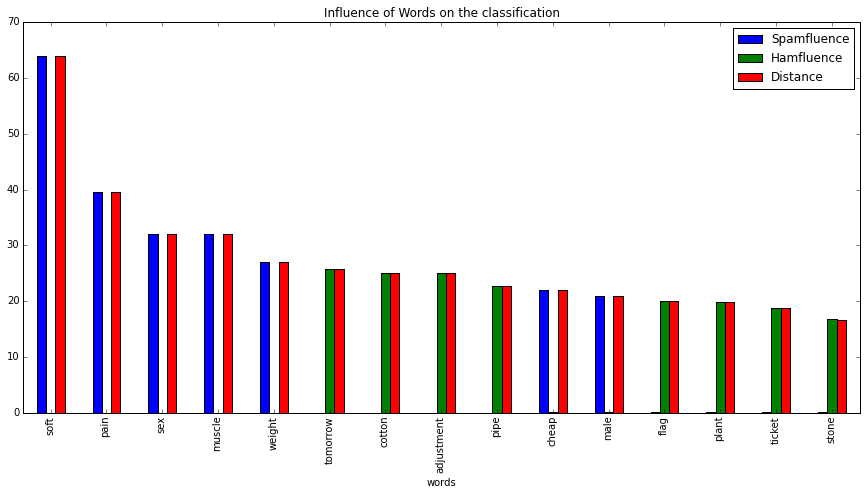

In [87]:
Info.set_index('words')[:15].plot(kind='bar',figsize=(15,7),title='Influence of Words on the classification')



As we can see, there are either words who are very similar or very different. Let's try to leverage this

In [88]:
Info.words[:300].to_csv('list2.txt',index=False)

new_dict = 'list2.txt'

test_words = pd.read_csv(new_dict, names=['words'], header=None)
ham_counter = pd.DataFrame()
spam_counter = pd.DataFrame()
spam_prior = 0
ham_prior = 0
spam_c = 0
ham_c = 0
ham_p = 0
spam_p = 0

In [89]:
spam_c,ham_c,spam_p,ham_p = train(dictionary=test_words)


C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:

spam_hits = list()
to_classify = listdir(unknown_spam)
for mails in to_classify:
    spam_hits.append(classify(unknown_spam + '\\' + mails,spam_c,ham_c,spam_p,ham_p,dictionary = test_words))
spam_hits = np.array(spam_hits)

ham_hits = list()
to_classify = listdir(unknown_ham)
for mails in to_classify:
    ham_hits.append(classify(unknown_ham + '\\' + mails,spam_c,ham_c,spam_p,ham_p,dictionary = test_words))
    
ham_hits = np.array(ham_hits)
ham_hits = abs(1-ham_hits)


In [91]:
np.mean(spam_hits), np.mean(ham_hits)





(0.42513368983957217, 0.96973171290988303)

In [92]:




complete_hits = np.concatenate((spam_hits, ham_hits))
np.mean(complete_hits)


0.83063001536622849